In [2]:
import itertools
import yaml

run_path = './runs_multicore'

device_list     = ['DDR4', 'DDR5', 'URAM4', 'URAM5', 'FURAM4', 'FURAM5']
org_list        = ['16Gb_x8']
timing_list     = {'DDR4': '3200AA', 'DDR5': '3200AN', 'URAM4': '3200AA', 'URAM5': '3200AN', 'FURAM4': '3200AA', 'FURAM5': '3200AN'}
row_policy_list = ['OpenRowPolicy']

group_list = ["HHHH", "HHHL", "HHLL", "HLLL", "LLLL"]
num_samples_per_group = 5
trace_list = [x[0] + str(x[1]) for x in itertools.product(group_list, range(num_samples_per_group))]

data = {}
for device in device_list:
  for org in org_list:
      for row_policy in row_policy_list:
        for trace in trace_list:
            run_file = f'{device}_{org}_{timing_list[device]}_{row_policy}_{trace}'
            with(open(f'{run_path}/{run_file}.yaml', 'r')) as f:
              data[run_file] = yaml.load(f, Loader=yaml.FullLoader)

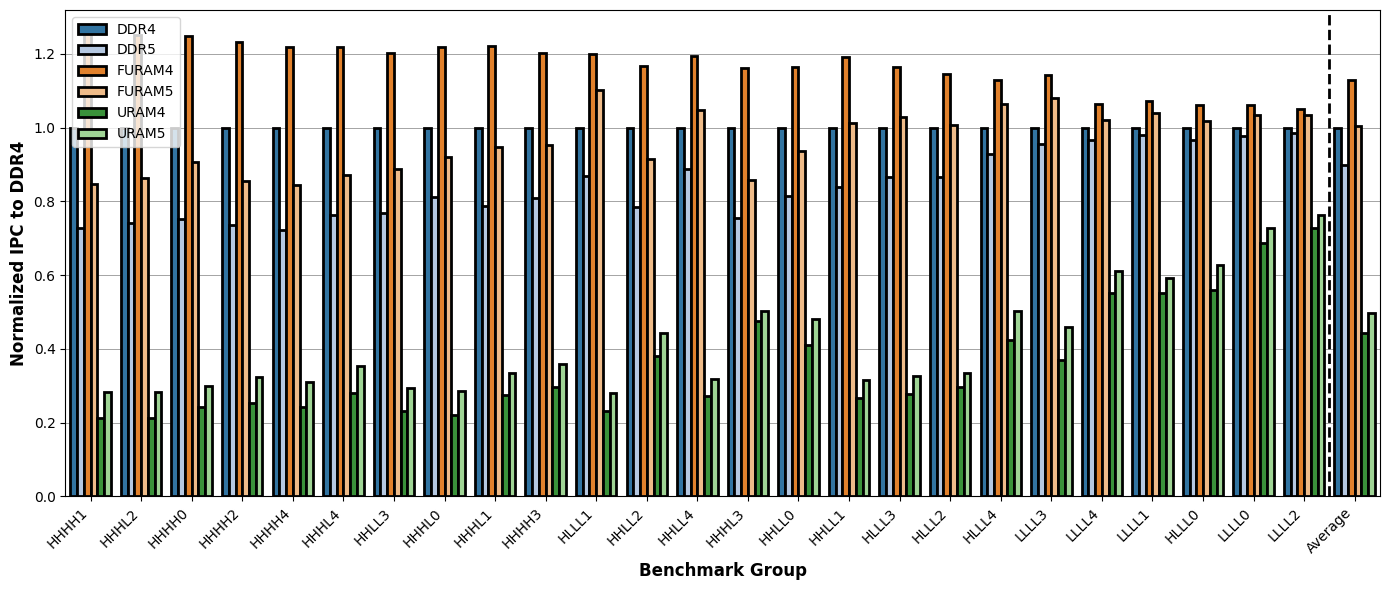

In [12]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device_list = ['DDR4', 'DDR5', 'FURAM4', 'FURAM5', 'URAM4', 'URAM5']
# device_list = ['DDR4', 'FURAM4', 'URAM4']
# device_list = ['DDR5', 'FURAM5', 'URAM5']
normalized_to = 'DDR4'
sort_by = 'URAM4'

total_executed_inst = data[f'{device_list[0]}_{org_list[0]}_{timing_list[device_list[0]]}_{row_policy_list[0]}_{trace}']['Frontend']['num_expected_insts']
for org in org_list:
  for row_policy in row_policy_list:

    ipc_list = {}
    for device in device_list:
      ipc_list[device] = []
      for trace in trace_list:
        total_recored_core_cycle = 0
        for i in range(4):
          total_recored_core_cycle += data[f'{device}_{org}_{timing_list[device]}_{row_policy}_{trace}']['Frontend'][f'cycles_recorded_core_{i}']
        ipc_list[device].append(total_executed_inst / total_recored_core_cycle)

    sorted_data = sorted(zip(trace_list, *[ipc_list[device] for device in device_list]),
                  key=lambda x: x[1 + device_list.index(sort_by)])
    
    benchmarks = []
    core_cycles = []
    devices = []

    for item in sorted_data:
        trace = item[0]
        device_data = item[1:]
        benchmarks.extend([trace] * len(device_list))
        core_cycles.extend([data / device_data[device_list.index(normalized_to)] for data in device_data])
        devices.extend(device_list)

    avg_list = []
    for device in device_list:
      avg_list.append(np.mean(ipc_list[device] / np.mean(ipc_list[normalized_to])))

    benchmarks.extend(['Average'] * len(device_list))
    core_cycles.extend(avg_list)
    devices.extend(device_list)

    df = pd.DataFrame({
    'Benchmark Group': benchmarks,
    f'Normalized IPC to {normalized_to}': core_cycles,
      'Device': devices
    })

    plt.figure(figsize=(14, 6))
    barplot = sns.barplot(x='Benchmark Group', y=f'Normalized IPC to {normalized_to}', hue='Device', 
                          edgecolor='black', linewidth=2, 
                          palette=sns.color_palette('tab20', n_colors=len(device_list)),
                          zorder=2, data=df)

    barplot.legend(loc='upper left')
    barplot.set_xlabel('Benchmark Group', fontsize=12, fontweight='bold')
    barplot.set_ylabel(f'Normalized IPC to {normalized_to}', fontsize=12, fontweight='bold')
    barplot.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5, color='gray', zorder=0)

    plt.xticks(rotation=45, ha='right')
    plt.axvline(x=len(trace_list) - 0.5, color='black', linestyle='--', linewidth=2)

    plt.tight_layout()
    plt.show()